In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pytorch_ssim
# https://github.com/Po-Hsun-Su/pytorch-ssim
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device =torch.device("cpu")
# 选择 dataset
dataset = 'MNIST' 
#dataset = "CIFAR-10"
batch_size = 50
eps = 0.031 if dataset=="CIFAR-10" else 0.3
step_size = 0.05 if dataset=="CIFAR-10" else 0.15
iteration = 10
K = 0.05

In [3]:
def filter_state_dict(state_dict):
    from collections import OrderedDict

    if 'state_dict' in state_dict.keys():
        state_dict = state_dict['state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if 'sub_block' in k:
            continue
        if 'module' in k:
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
if(dataset == "CIFAR-10"):
    test_dataset = torchvision.datasets.CIFAR10("data_CIFAR10",train=False,download=True,transform = transform)
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    from PreActResNet18 import PreActResNet18
    # novel CIFAR10
    #from CIFAR10_preactresnet18 import PreActResNet18
    from wideresnet import WideResNet
    #model = PreActResNet18()
    net = PreActResNet18(num_classes=10)
    #model = WideResNet(34, 10)
    #check_point = torch.load("pretrained_model/AT-AWP_cifar10_l2_preactresnet18.pth", map_location=torch.device(device))
    ckpt = filter_state_dict(torch.load("pretrained_model/AT-AWP_cifar10_l2_preactresnet18.pth", map_location=device))
    #check_point = torch.load("pretrained_model/CIFAR10_PreActResNet18.checkpoint", map_location=torch.device(device))
    #check_point = torch.load("pretrained_model/AT-AWP_cifar10_linf_wrn34-10.pth", map_location=torch.device(device))
    #model.load_state_dict(check_point['state_dict'])
    #mean = (0, 0, 0)
    #std = (1, 1, 1)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2471, 0.2435, 0.2616)    
    net.load_state_dict(ckpt)
    model = nn.Sequential(Normalize(mean=mean, std=std), net)
    model.to(device)
else:
    test_dataset = torchvision.datasets.MNIST("data_MNIST", train=False, download=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    from small_cnn import SmallCNN
    from model import *
    #model = SmallCNN()
    model = LeNet5()
    #check_point = torch.load("pretrained_model/MNIST_small_cnn.checkpoint", map_location=torch.device(device))
    check_point = torch.load("pretrained_model/adv_trained_lenet5.pkl", map_location=torch.device(device))
    model.load_state_dict(check_point)
    #model.load_state_dict(check_point['state_dict'])
    model.to(device)

In [5]:
# 显示一张图片（没有transpose)
def imshow(img, title):
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(img.cpu(),(1,2,0)))
    plt.title(title)
    plt.show()

In [6]:
# 并排左右显示两张图片（没有transpose)
def double_imshow(img1,img2,title1,title2):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 2),(0, 0))
    plt.imshow(np.transpose(img1.cpu(),(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(np.transpose(img2.cpu(), (1, 2, 0)))
    i2.set_title(title2)
    plt.show()


In [7]:
# savepath = "adv_images/SSIM, step_size = 0.15 eps = 0.3/"
# 并排左右显示三张图片（没有transpose)
def triple_imshow(img1, img2, img3, title1, title2, title3, figNum = 0):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 3),(0, 0))
    plt.imshow(np.transpose(img1.cpu(),(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 3), (0, 1))
    plt.imshow(np.transpose(img2.cpu(), (1, 2, 0)))
    i2.set_title(title2)
    i3 = plt.subplot2grid((1, 3), (0, 2))
    plt.imshow(np.transpose(img3.cpu(), (1, 2, 0)))
    i3.set_title(title3)
    # sp = savepath + "img" + str(figNum) + '.png'
    # plt.savefig(sp)
    plt.show()

In [8]:
# l2 Loss
def l2(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0.0
    for i in range(0,channel):
        for j in range(0,height):
            for k in range(0, width):
                total_dif += (img1[i][j][k].item()-img2[i][j][k].item()) ** 2
    return total_dif ** 0.5

In [9]:
# l1 Loss
def l1(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += abs(img1[i][j][k].item() - img2[i][j][k].item())
    return total_dif

In [10]:
# l0 Loss 计算差距<=0.01像素点的数目
def l0(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += 0 if abs(img1[i][j][k].item() - img2[i][j][k].item()) <= 0.01 else 1
    return total_dif

In [11]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, outputs, delta, labels, lam1 ,lam2):
        mask = torch.ones_like(outputs).scatter_(1, labels.unsqueeze(1), 0.)
        rest = outputs[mask.bool()].view(outputs.size(0), outputs.size(1) - 1)
        xx = torch.tensor(range(outputs.size(0)))
        f = torch.nn.ReLU()
        L_inf = lam1 * (eps + torch.max(delta))
        L_ssim = lam2 * (pytorch_ssim.ssim(images,images+delta,size_average = False))
        return torch.mean(f(outputs[xx, labels] - torch.max(rest, 1)[0] + K) +  L_inf + L_ssim )

In [12]:
def PGD_attack_MyLoss(net, images, labels, eps, step_size):
    images = images.to(device)
    labels = labels.to(device)

    delta = torch.zeros(images.size()).to(device)  #变量求导
    lam1 = torch.zeros(1).to(device)
    lam2 = torch.zeros(1).to(device)
    
    delta = Variable(delta, requires_grad=True)
    lam1 = Variable(lam1, requires_grad=True)
    lam2 = Variable(lam2, requires_grad=True)
    # random_noise = torch.FloatTensor(*images.shape).uniform_(-eps, eps).to(device)
    # images = images.data + random_noise
    # print(images.size())
    # print(labels.size())
    # ori_images = images.data
    criterion = My_loss()
    for i in range(iteration):
        # delta.requires_grad = True
        # lam.requires_grad = True
        # print(images.size())
        outputs = net(images + delta)
        net.zero_grad()
        loss = criterion(images, outputs, delta, labels, lam1, lam2).to(device)
        loss.backward()

        # print(delta.grad)
        new_delta = delta - 1 * delta.grad.detach()
        adv_images = torch.clamp(images + new_delta, min=0, max=1)
        delta = adv_images - images
        # delta = torch.clamp(delta, min=-eps, max=eps)
        
        new_lam1 = lam1 + 1 * lam1.grad.detach()
        if new_lam1 < 0:
            lam1 = torch.zeros(1).to(device)
        else:
            lam1 = new_lam1
        
        new_lam2 = lam2 + 2 * lam2.grad.detach()
        if new_lam2 < 0:
            lam2 = torch.zeros(1).to(device)
        else:
            lam2 = new_lam2
        delta = Variable(delta, requires_grad=True)
        lam1 = Variable(lam1, requires_grad=True)
        lam2 = Variable(lam2, requires_grad=True)
        # for i in range(0, images.size()[0]):
        #     print(torch.max(delta[i]).item())
        #     print(torch.min(delta[i]).item())

    deltas = []
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return images + delta, deltas

In [13]:
def PGD_attack_Conventional(model, image, label, eps, step_size, iters=10):
    image = image.to(device)
    label = label.to(device)
    loss = nn.NLLLoss()
    ori_image = image.data

    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()
        adv_image = image + step_size * image.grad.sign()
        delta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + delta, min=0, max=1).detach_()
    deltas = []
    delta = image-ori_image 
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return image ,deltas 

Total Image Count: 5 Success Rate:
 Novel Approach: 0.9387755102040817 Conventional Approach: 0.8979591836734694
Total Image Count: 10 Success Rate:
 Novel Approach: 0.9587628865979382 Conventional Approach: 0.8969072164948454
Total Image Count: 15 Success Rate:
 Novel Approach: 0.9586206896551724 Conventional Approach: 0.903448275862069
Total Image Count: 20 Success Rate:
 Novel Approach: 0.9581151832460733 Conventional Approach: 0.9162303664921466
Total Image Count: 25 Success Rate:
 Novel Approach: 0.9541666666666667 Conventional Approach: 0.9166666666666666
Total Image Count: 30 Success Rate:
 Novel Approach: 0.9543859649122807 Conventional Approach: 0.9192982456140351
Total Image Count: 35 Success Rate:
 Novel Approach: 0.9610778443113772 Conventional Approach: 0.9251497005988024
Total Image Count: 40 Success Rate:
 Novel Approach: 0.9607329842931938 Conventional Approach: 0.9240837696335078
Total Image Count: 45 Success Rate:
 Novel Approach: 0.9605568445475638 Conventional Appro

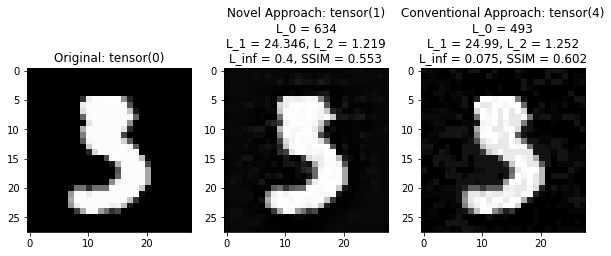

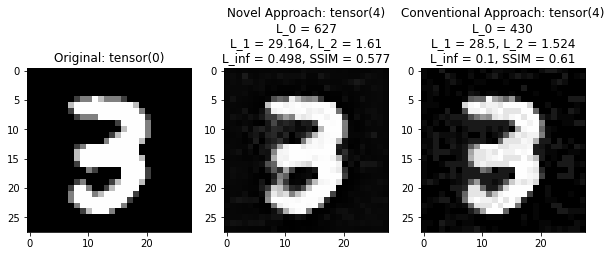

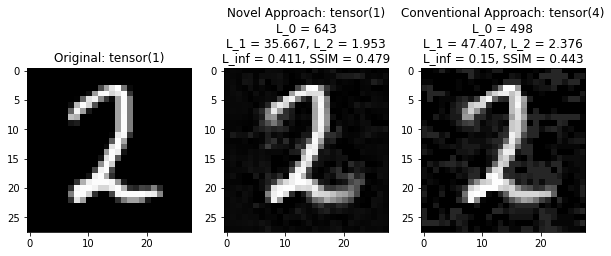

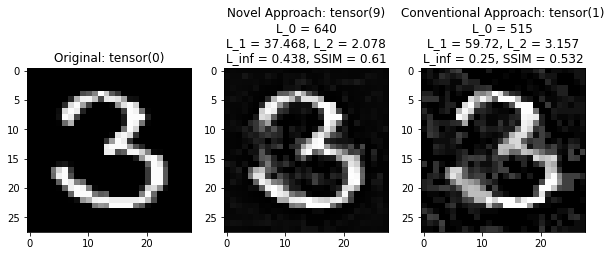

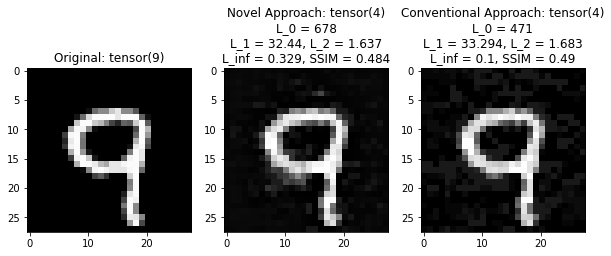

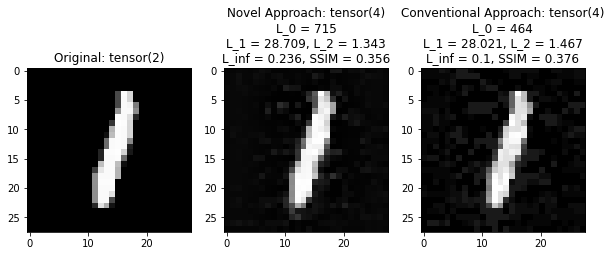

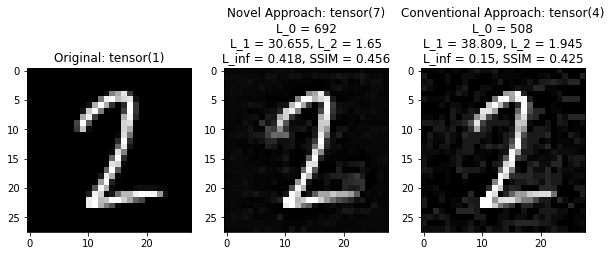

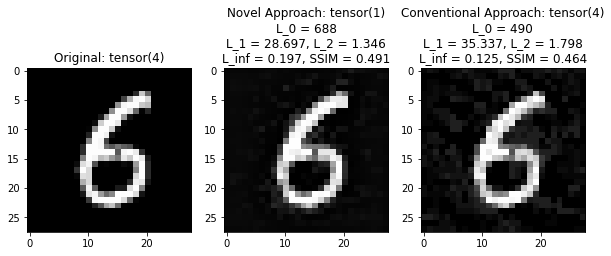

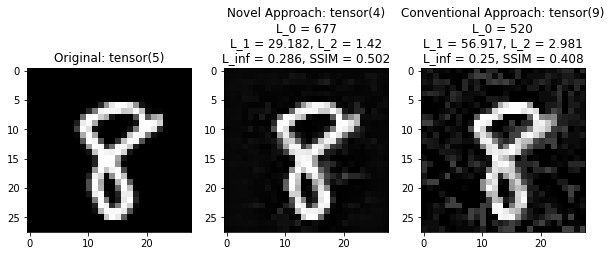

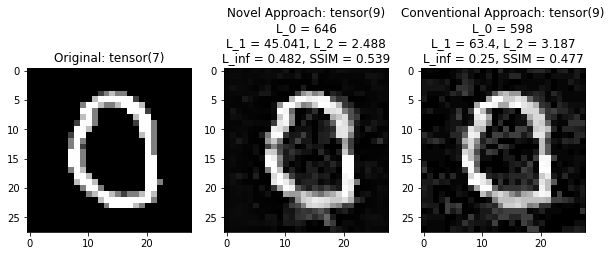

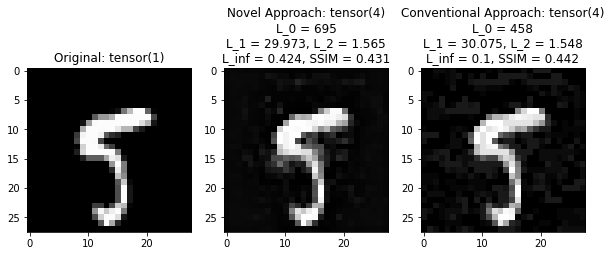

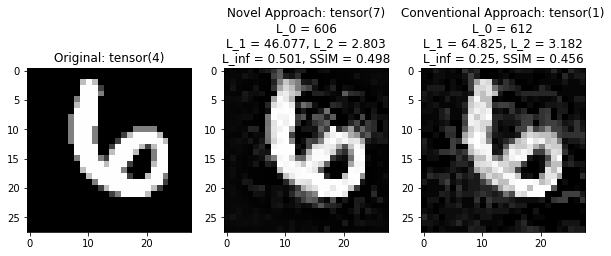

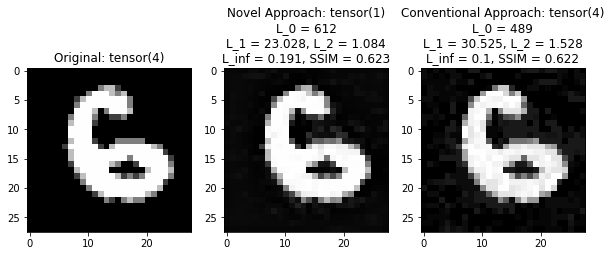

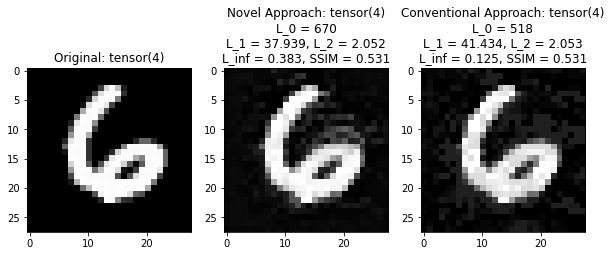

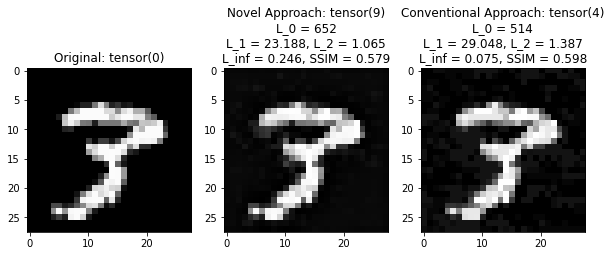

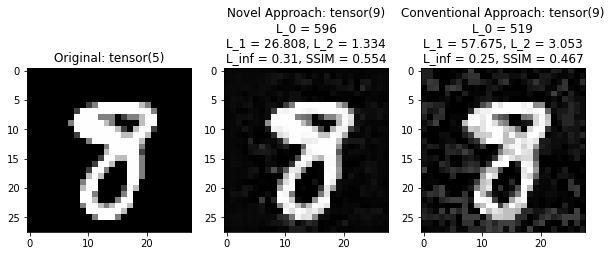

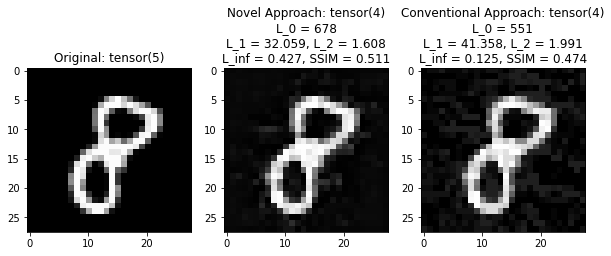

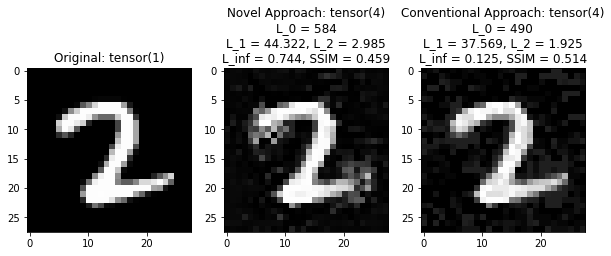

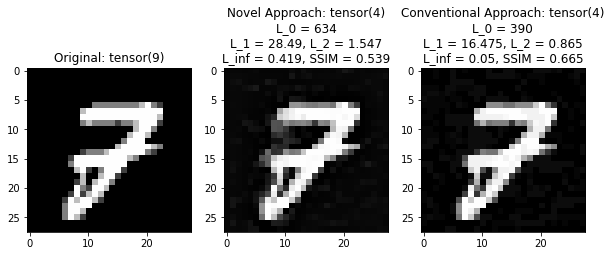

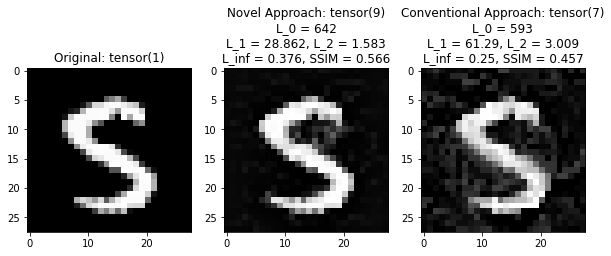

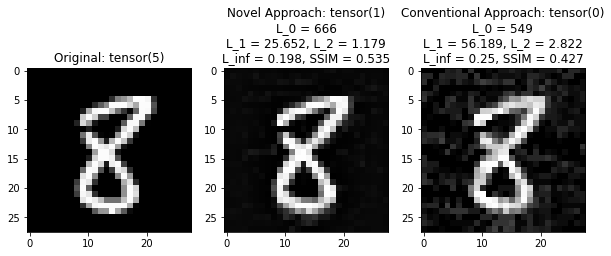

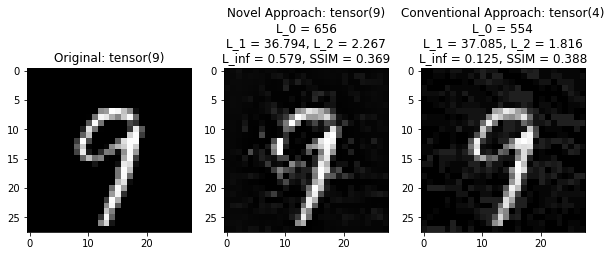

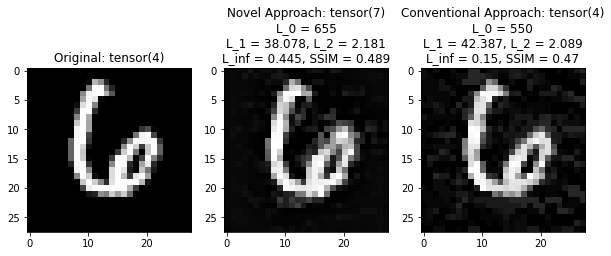

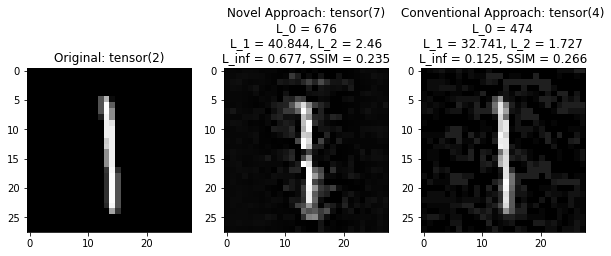

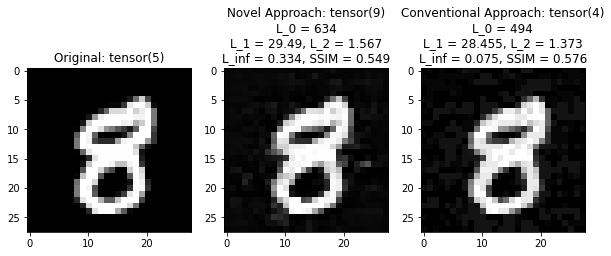

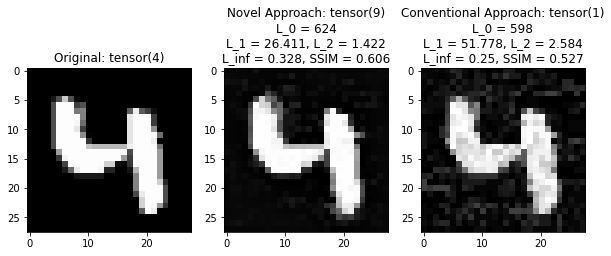

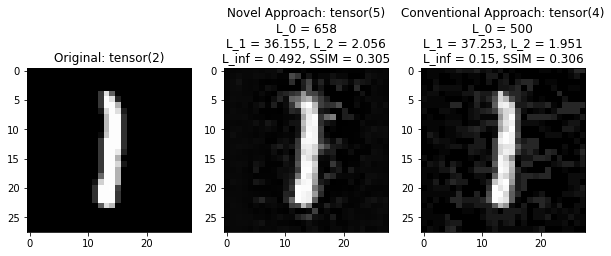

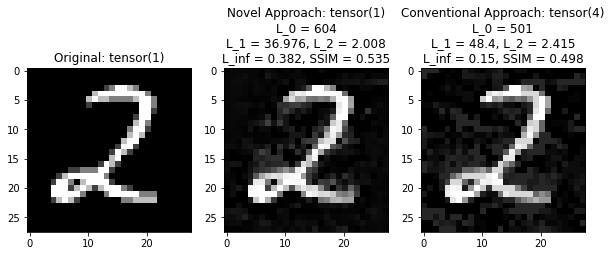

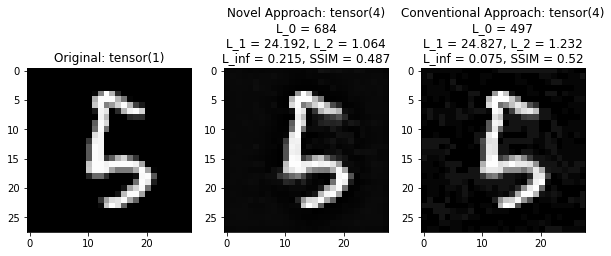

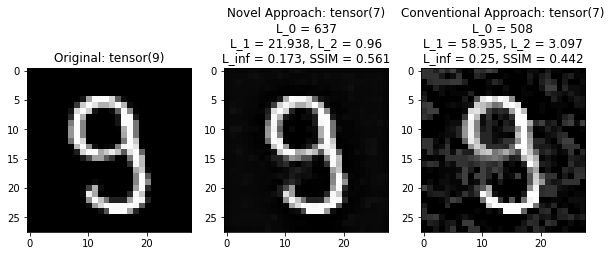

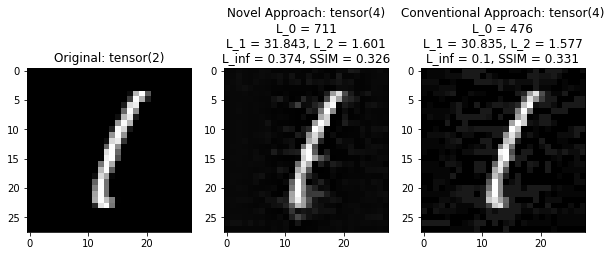

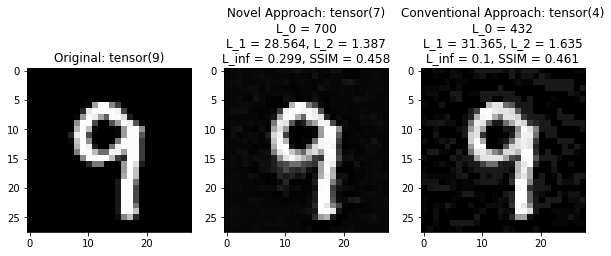

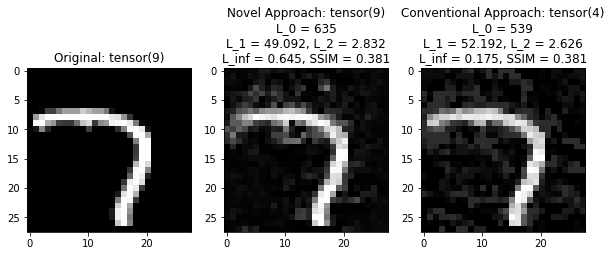

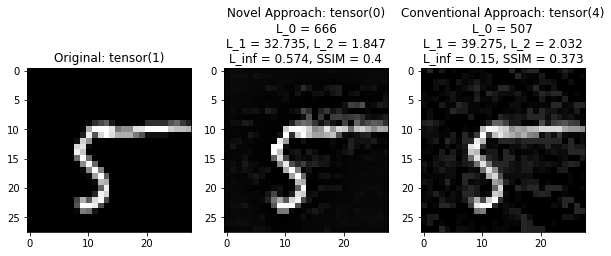

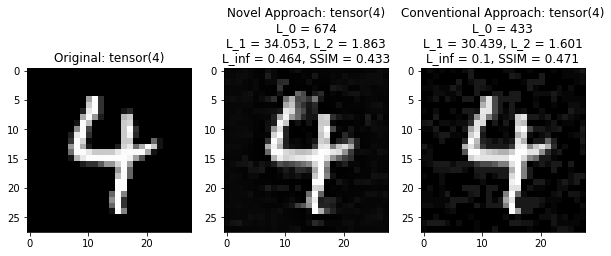

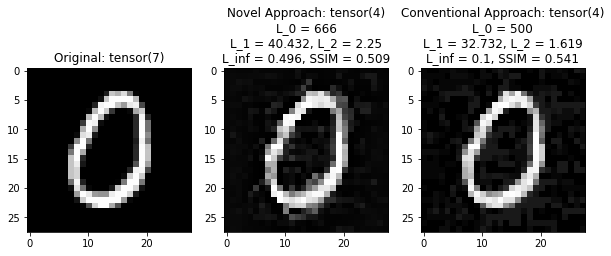

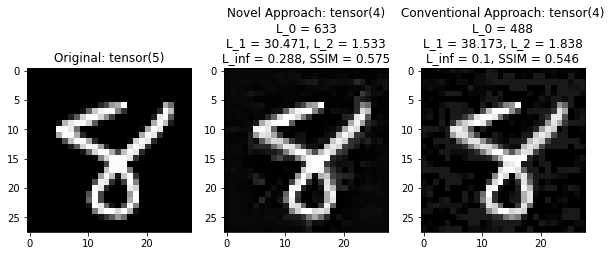

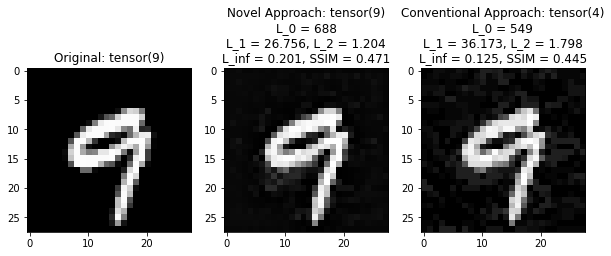

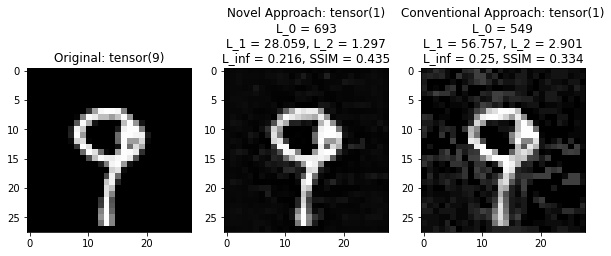

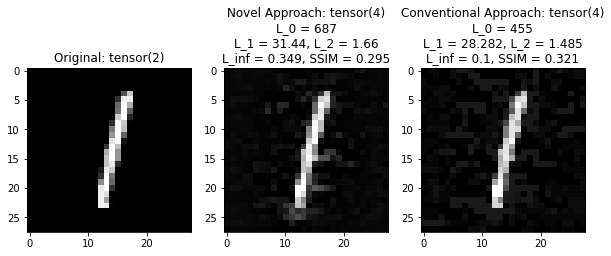

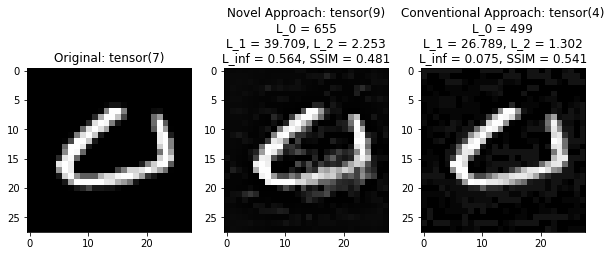

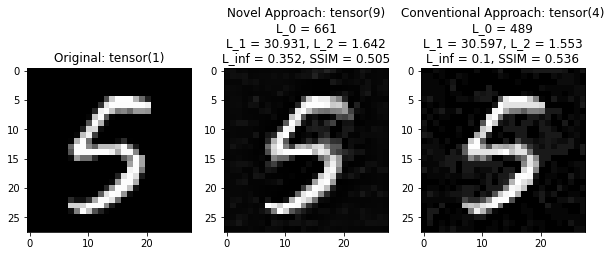

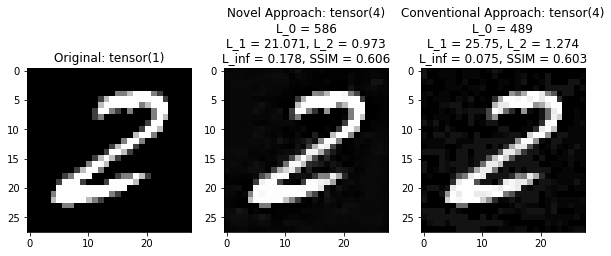

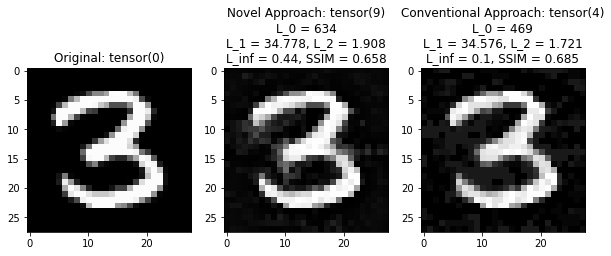

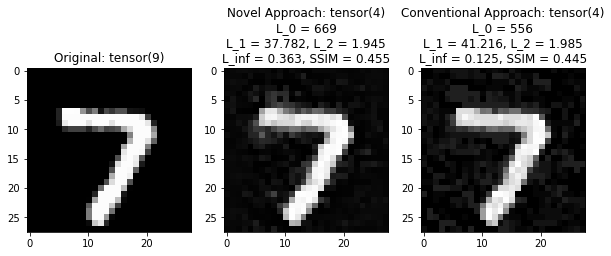

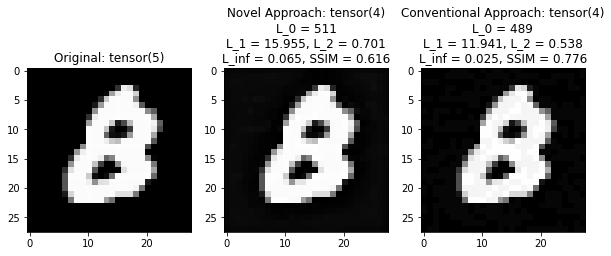

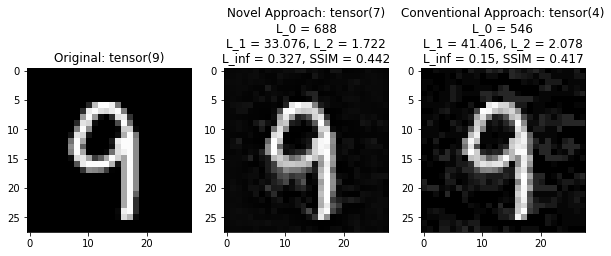

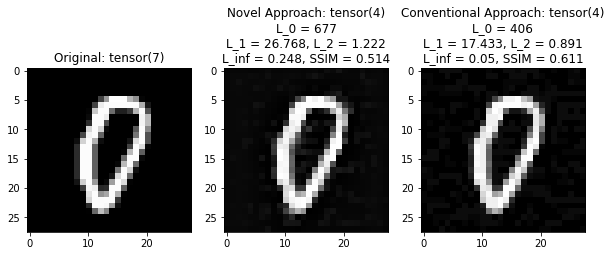

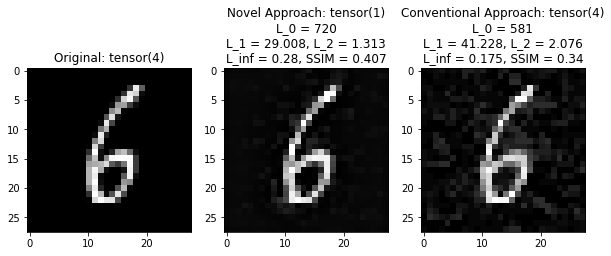

Total Image Count: 50 Success Rate:
 Novel Approach: 0.9583333333333334 Conventional Approach: 0.9291666666666667
Total Image Count: 55 Success Rate:
 Novel Approach: 0.9602272727272727 Conventional Approach: 0.9261363636363636
Total Image Count: 60 Success Rate:
 Novel Approach: 0.9616724738675958 Conventional Approach: 0.926829268292683
Total Image Count: 65 Success Rate:
 Novel Approach: 0.9630225080385852 Conventional Approach: 0.9308681672025724
Total Image Count: 70 Success Rate:
 Novel Approach: 0.9613095238095238 Conventional Approach: 0.9285714285714286
Total Image Count: 75 Success Rate:
 Novel Approach: 0.9610027855153204 Conventional Approach: 0.9261838440111421
Total Image Count: 80 Success Rate:
 Novel Approach: 0.9608355091383812 Conventional Approach: 0.9203655352480418
Total Image Count: 85 Success Rate:
 Novel Approach: 0.9607361963190184 Conventional Approach: 0.9214723926380368
Total Image Count: 90 Success Rate:
 Novel Approach: 0.9629629629629629 Conventional Appr

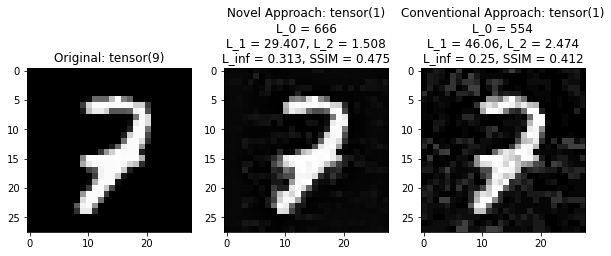

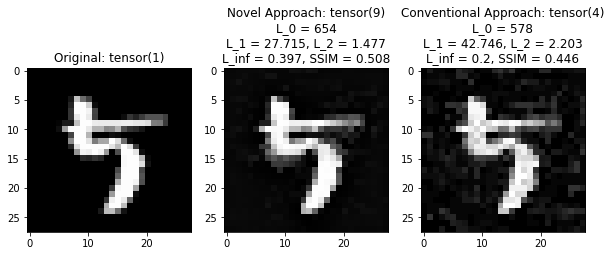

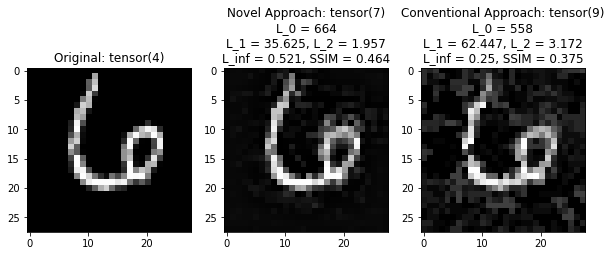

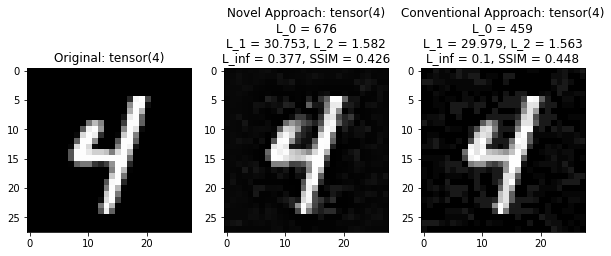

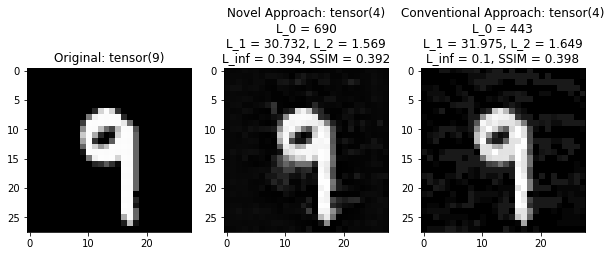

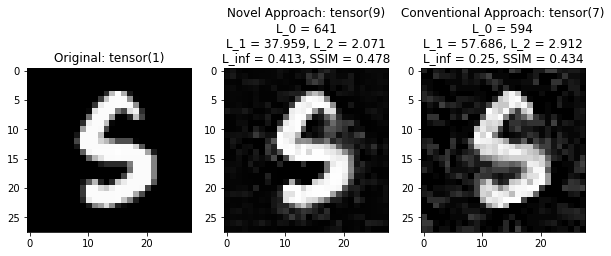

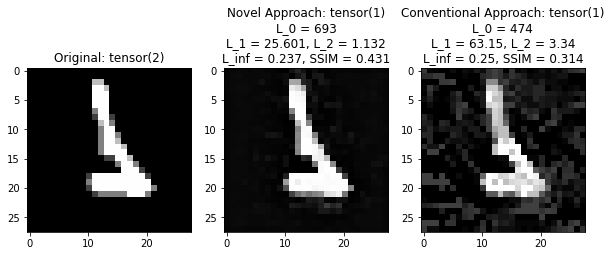

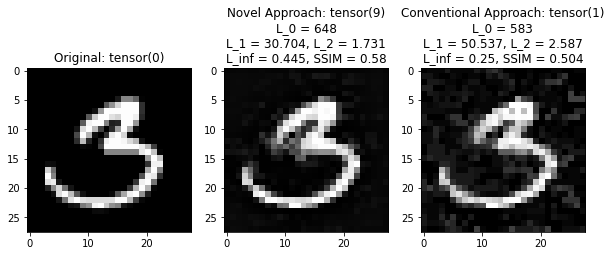

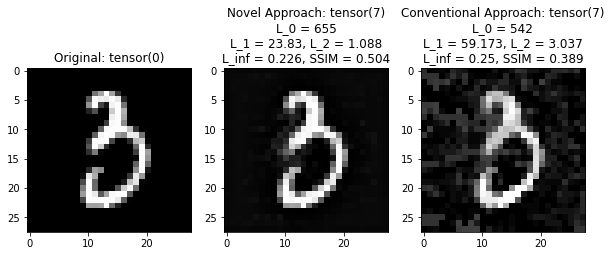

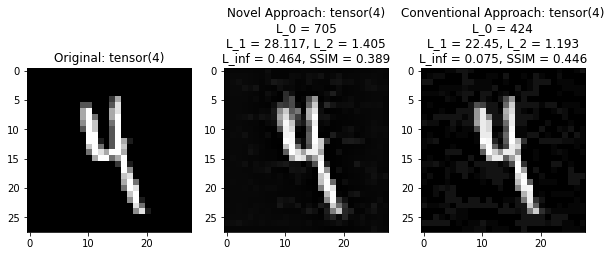

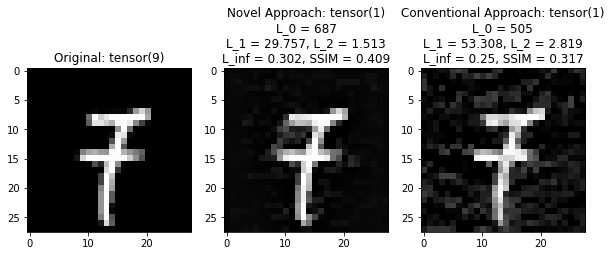

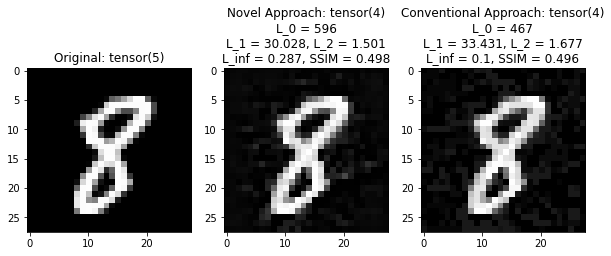

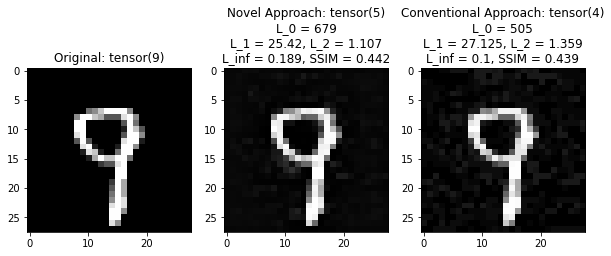

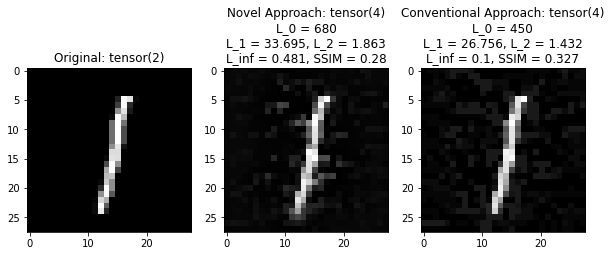

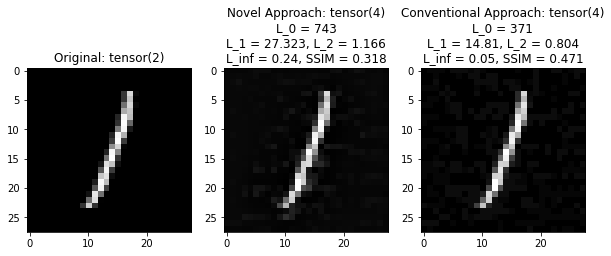

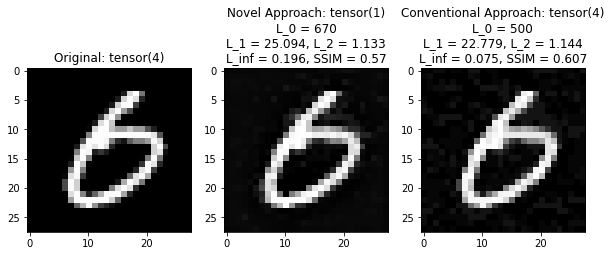

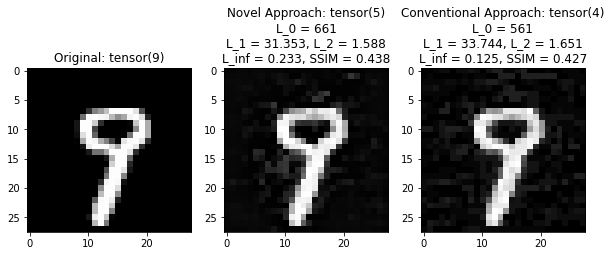

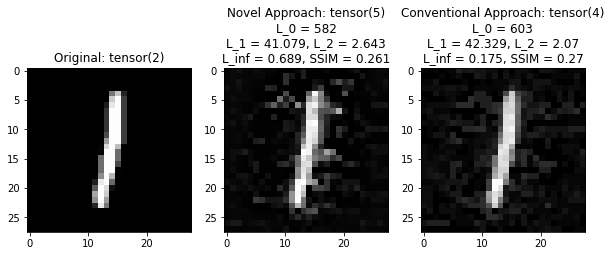

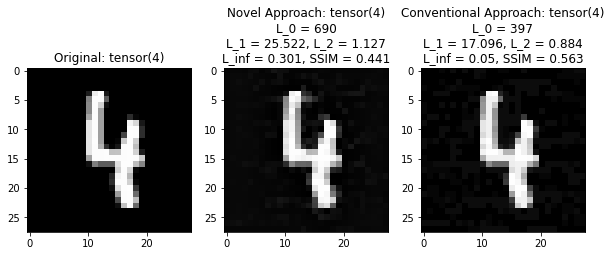

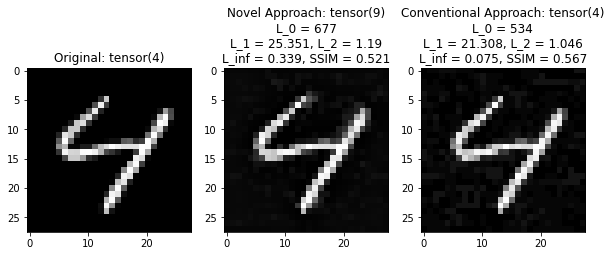

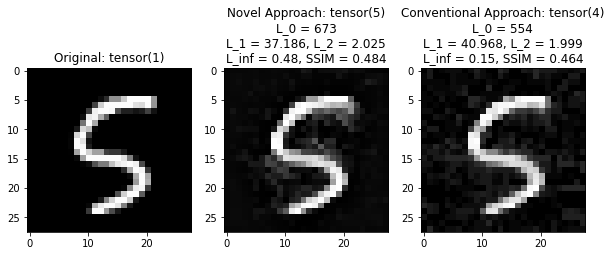

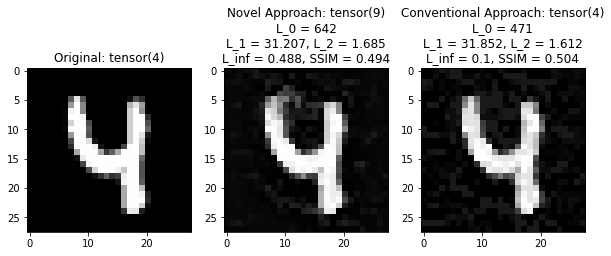

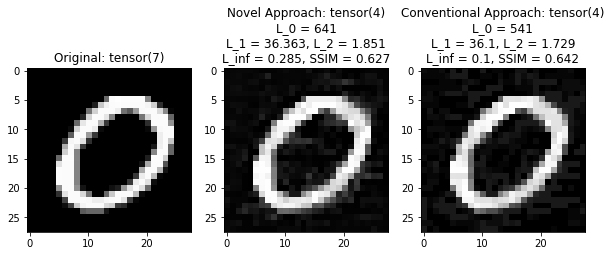

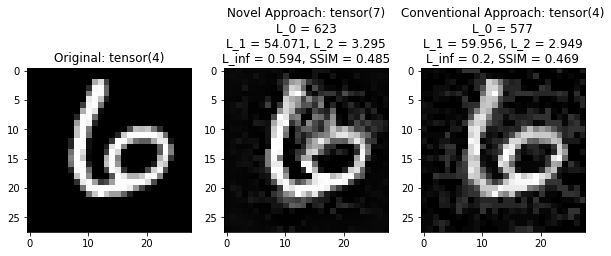

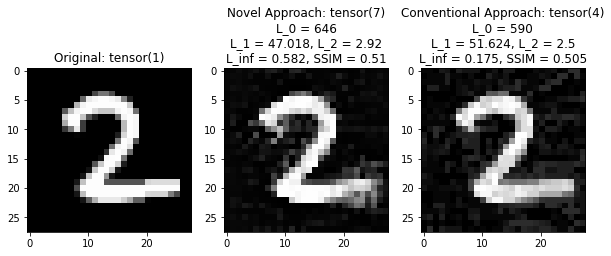

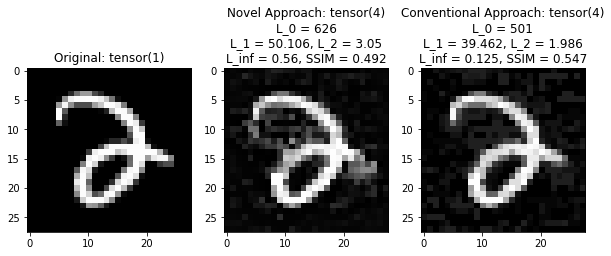

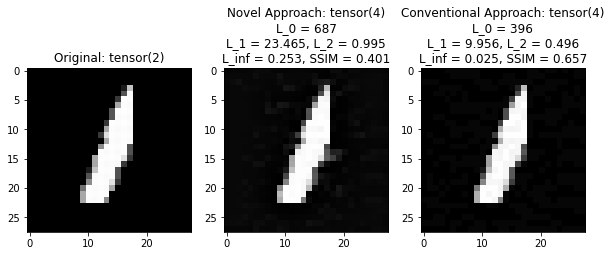

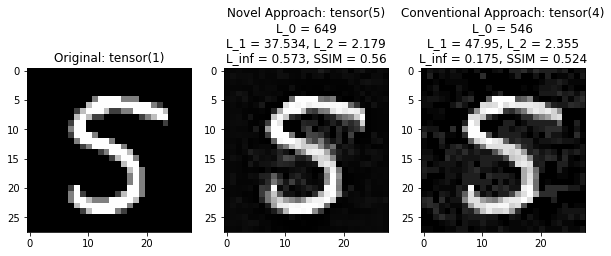

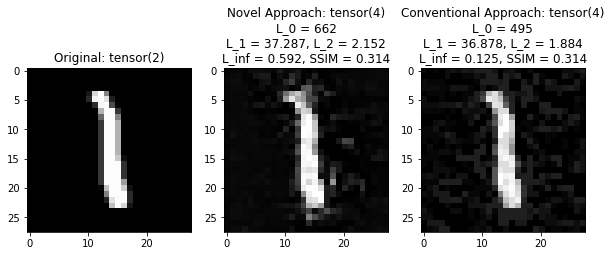

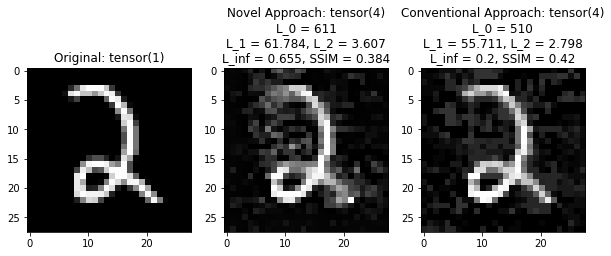

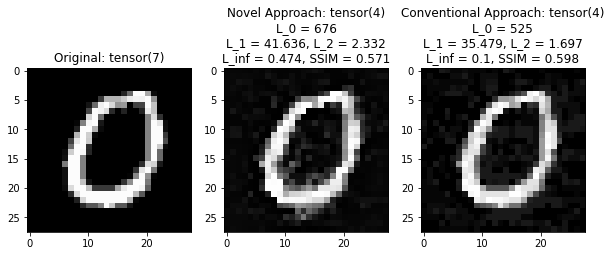

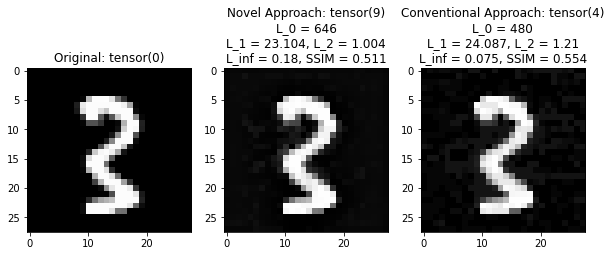

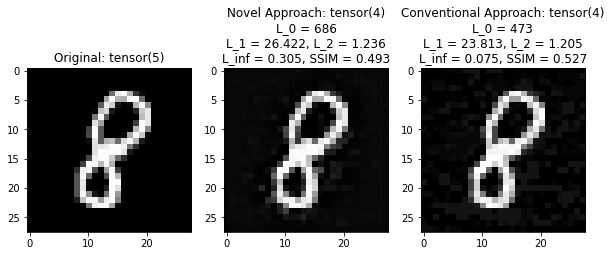

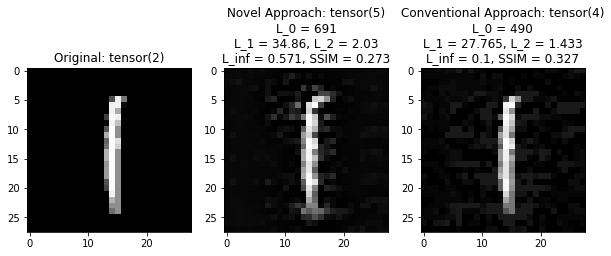

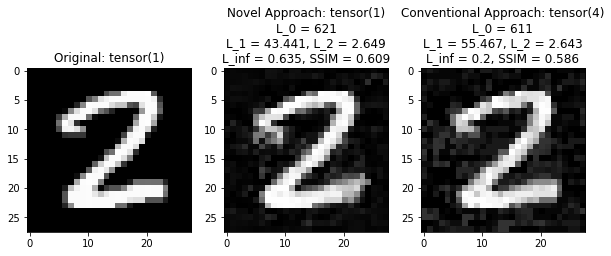

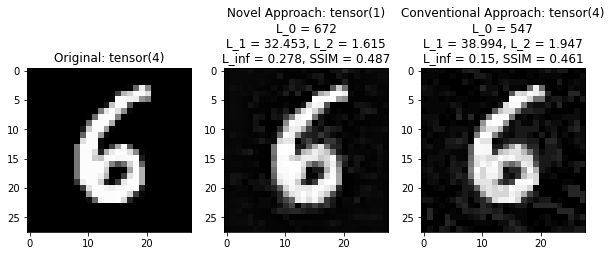

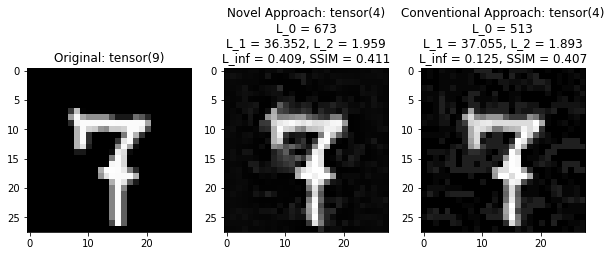

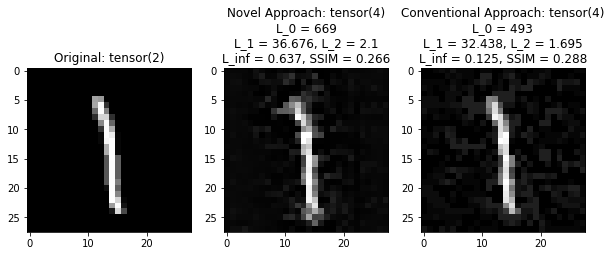

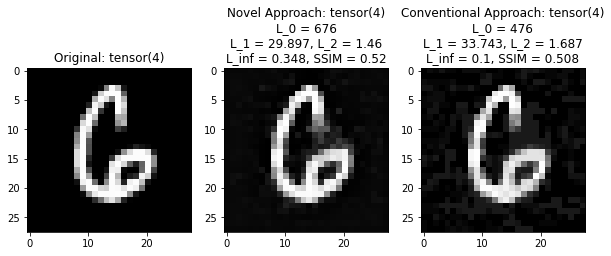

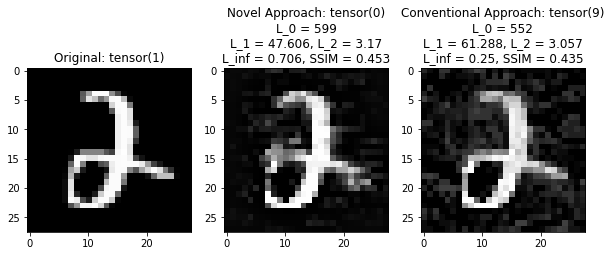

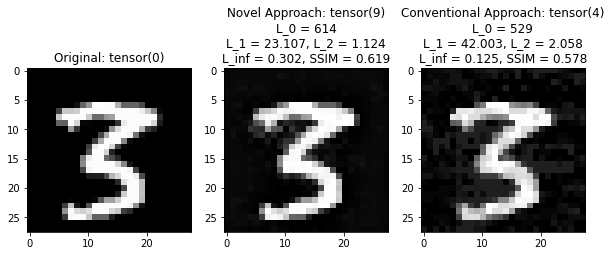

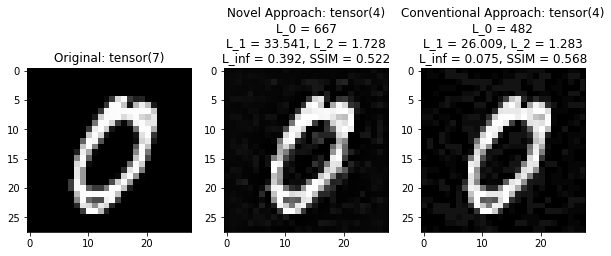

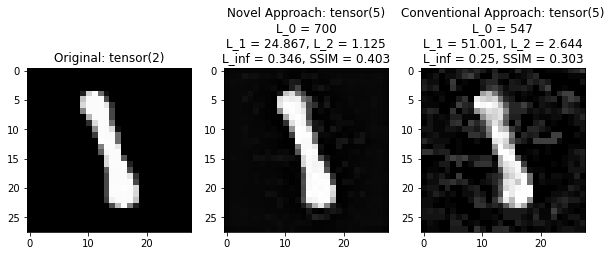

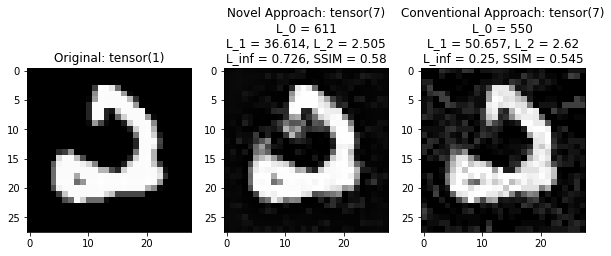

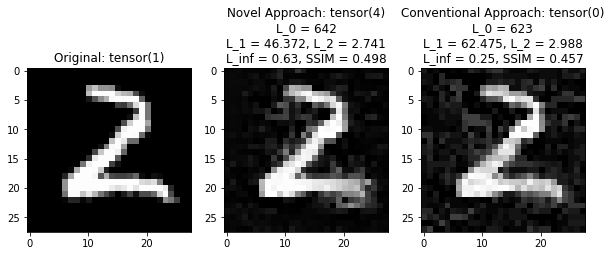

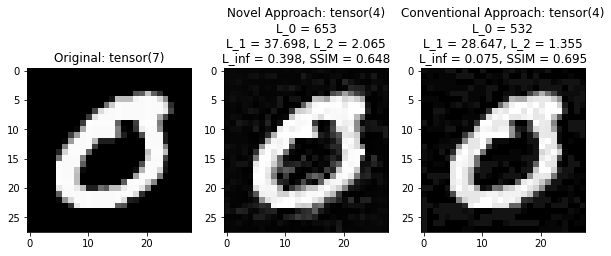

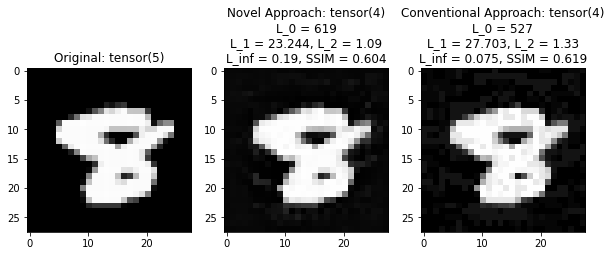

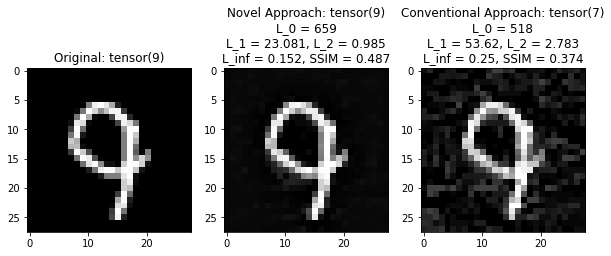

Total Image Count: 100 Success Rate:
 Novel Approach: 0.9602925809822361 Conventional Approach: 0.922675026123302
Total Image Count: 105 Success Rate:
 Novel Approach: 0.9611166500498505 Conventional Approach: 0.9232303090727817
Total Image Count: 110 Success Rate:
 Novel Approach: 0.9629629629629629 Conventional Approach: 0.9221272554605888
Total Image Count: 115 Success Rate:
 Novel Approach: 0.9627272727272728 Conventional Approach: 0.9209090909090909
Total Image Count: 120 Success Rate:
 Novel Approach: 0.960801393728223 Conventional Approach: 0.9198606271777003
Total Image Count: 125 Success Rate:
 Novel Approach: 0.961441743503772 Conventional Approach: 0.9212070410729254
Total Image Count: 130 Success Rate:
 Novel Approach: 0.9620967741935483 Conventional Approach: 0.9209677419354839
Total Image Count: 135 Success Rate:
 Novel Approach: 0.9612102404965089 Conventional Approach: 0.9193173002327386
Total Image Count: 140 Success Rate:
 Novel Approach: 0.9626028421839941 Convention

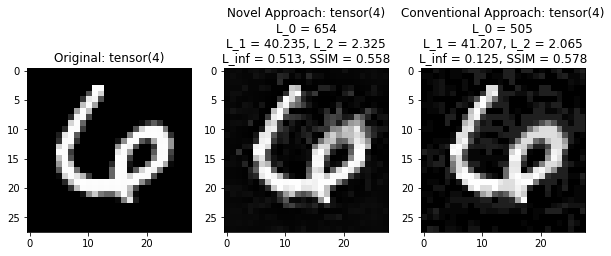

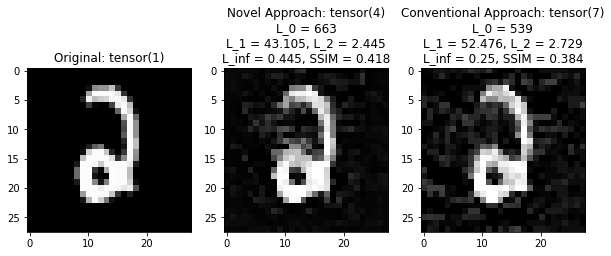

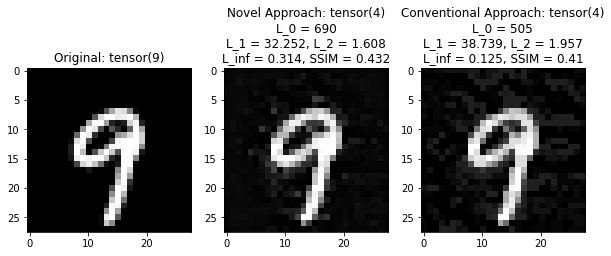

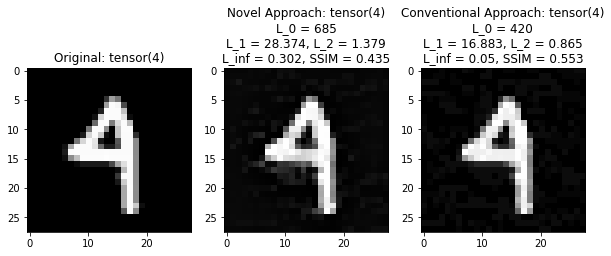

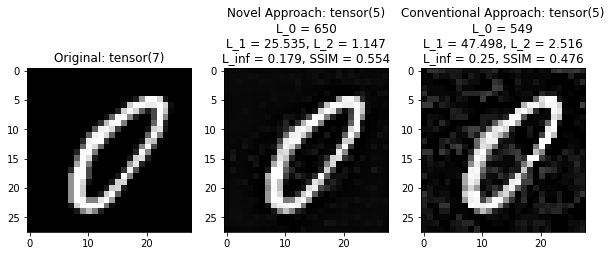

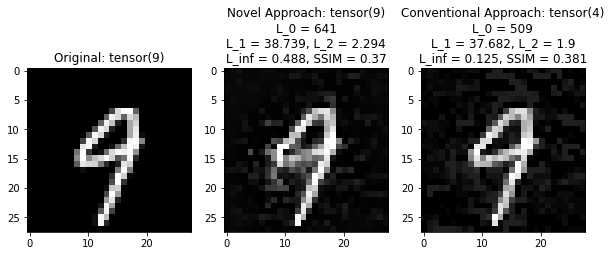

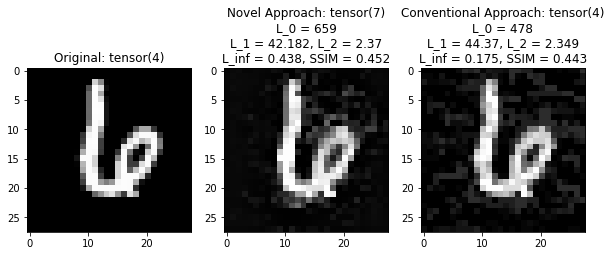

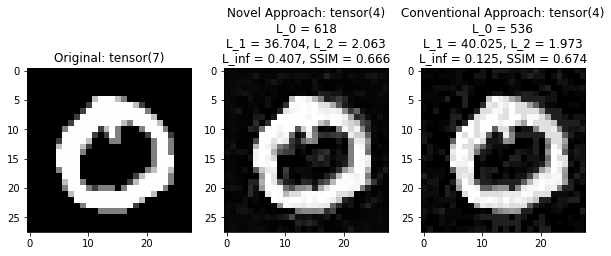

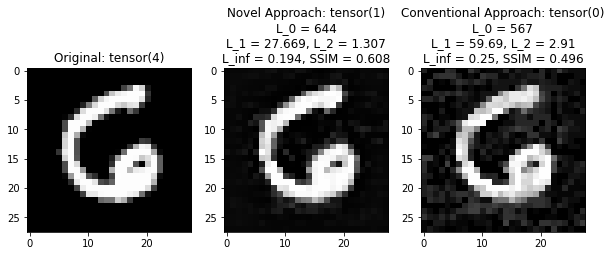

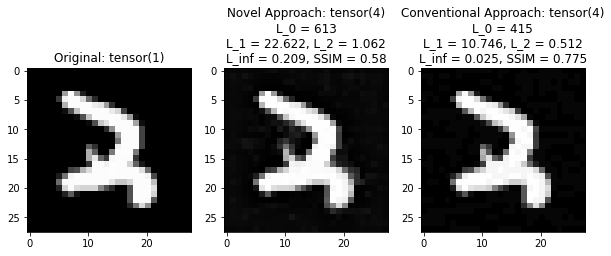

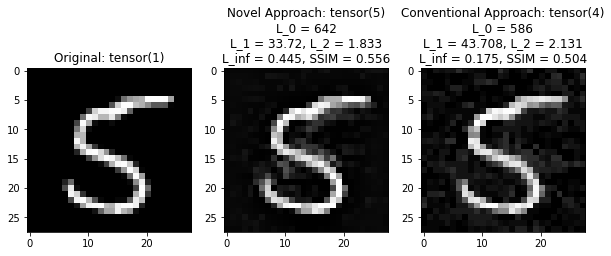

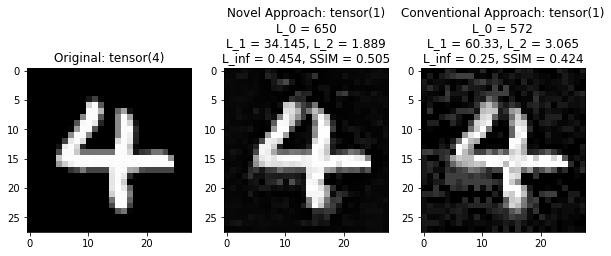

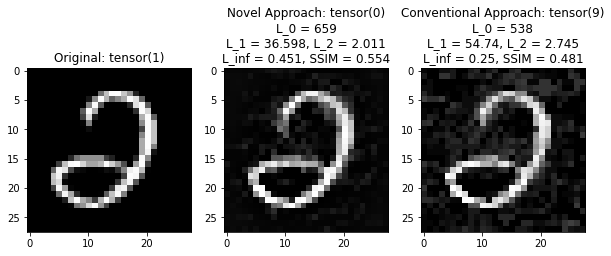

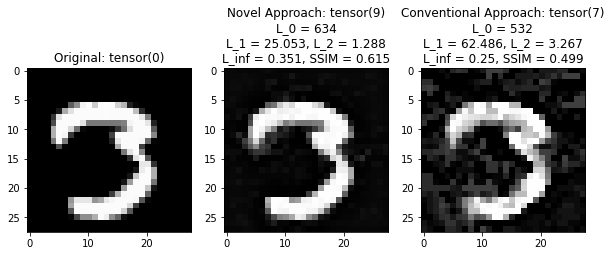

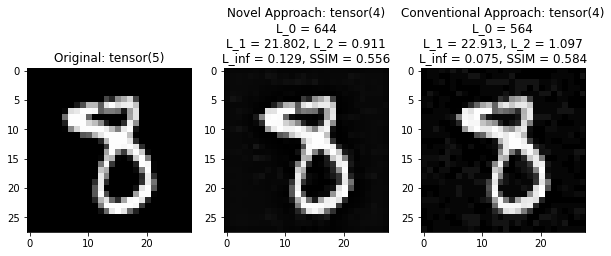

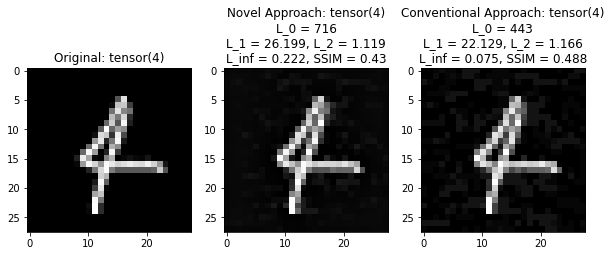

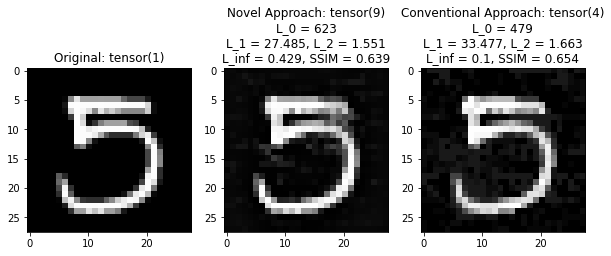

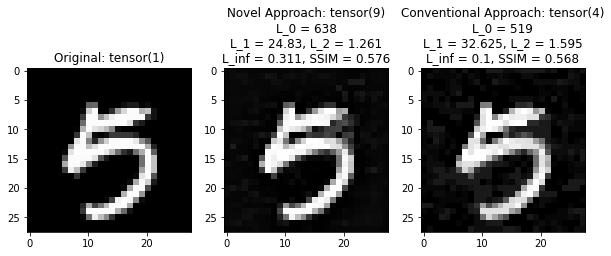

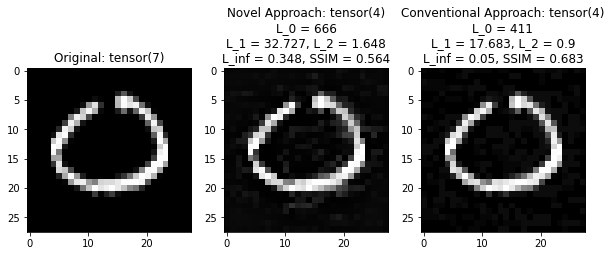

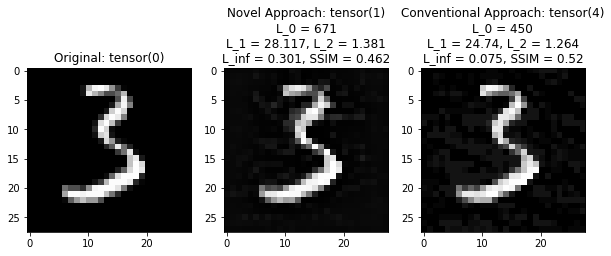

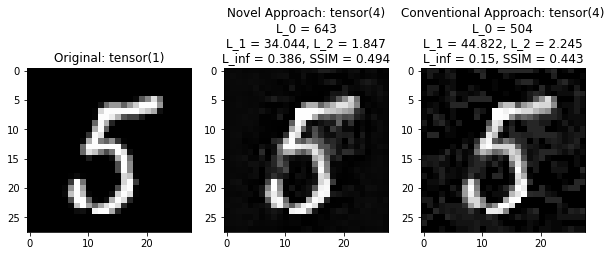

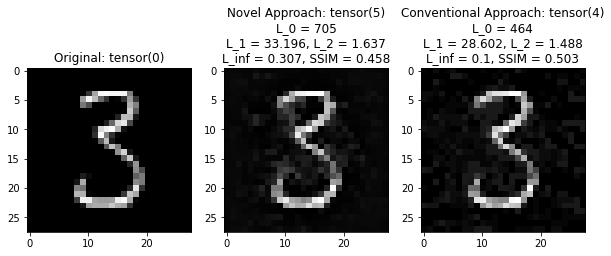

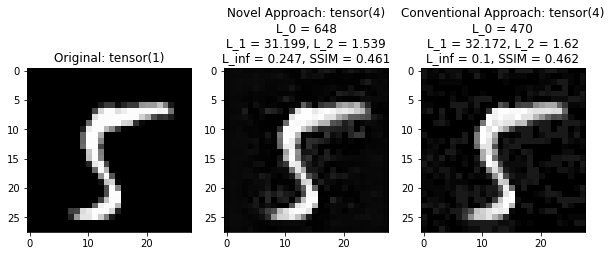

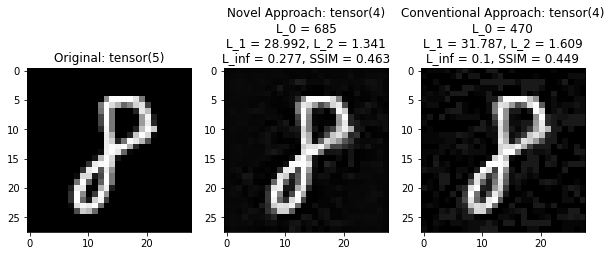

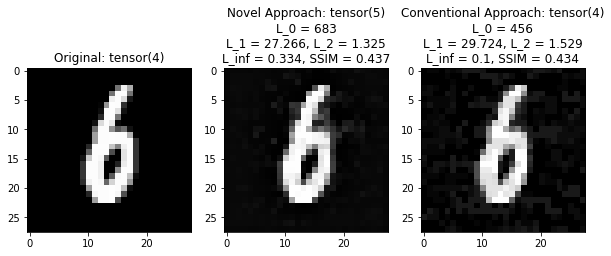

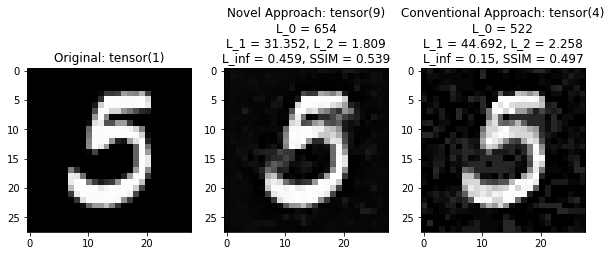

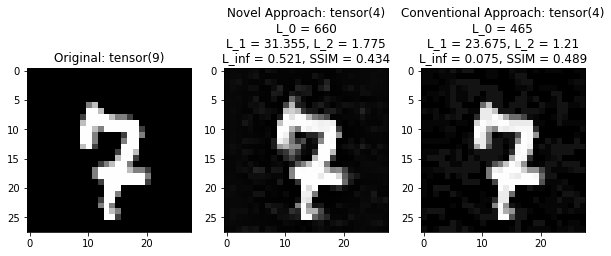

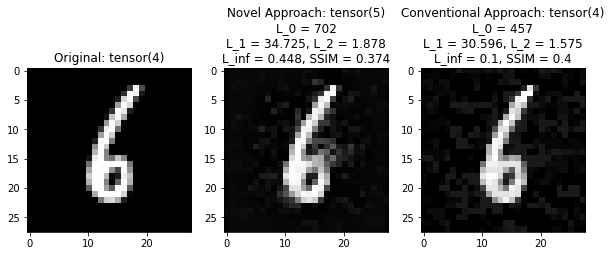

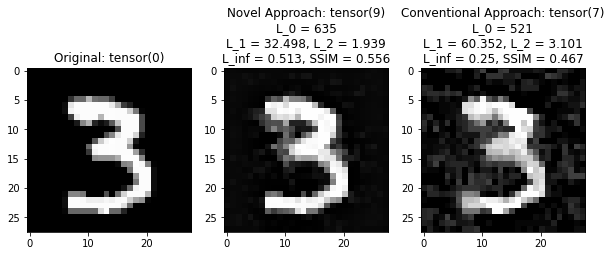

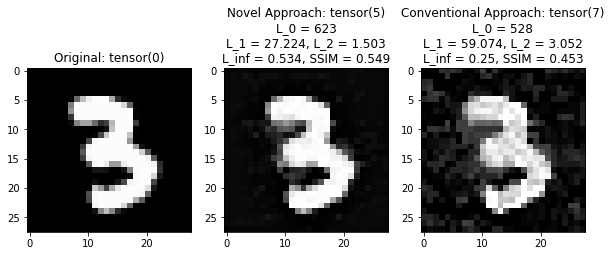

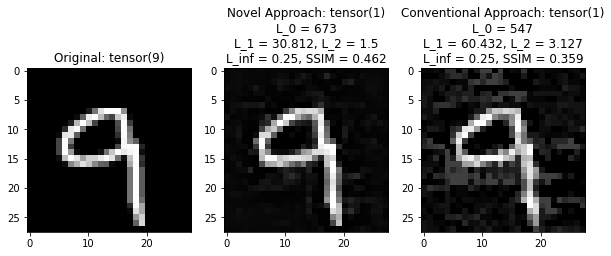

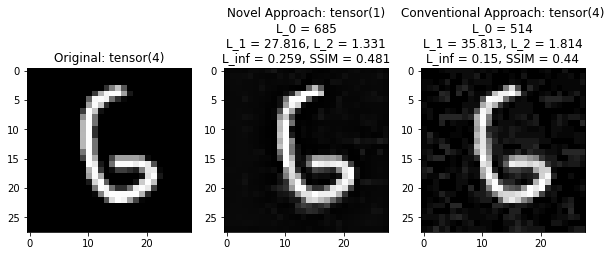

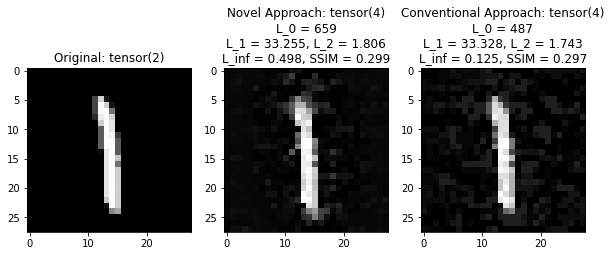

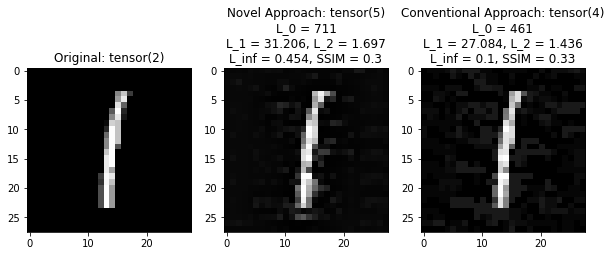

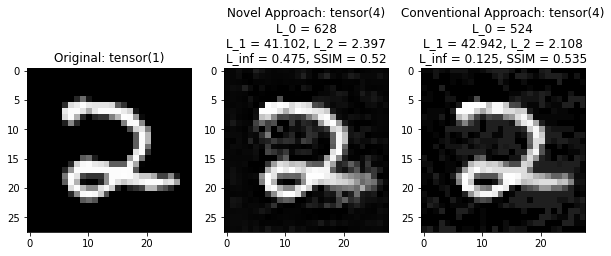

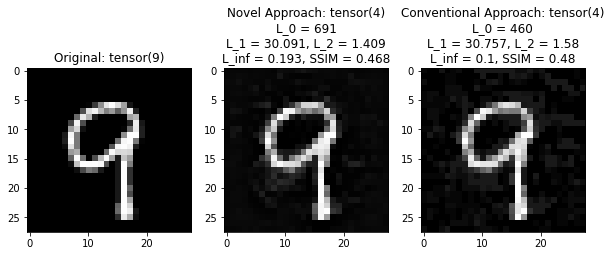

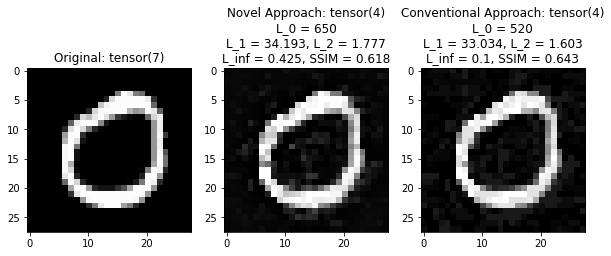

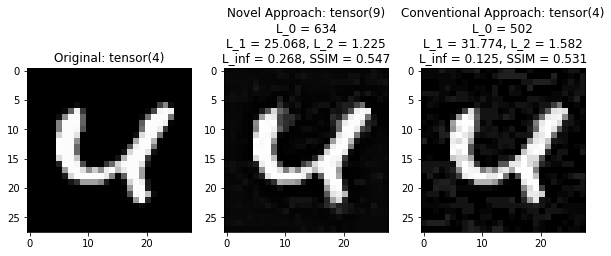

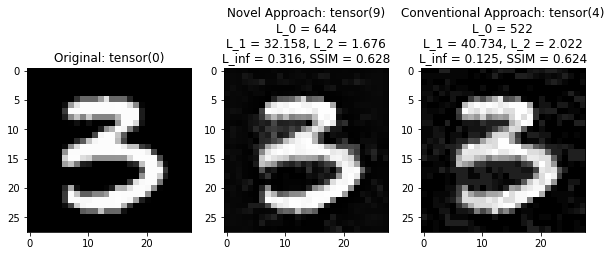

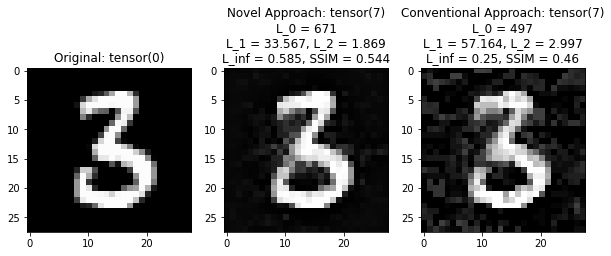

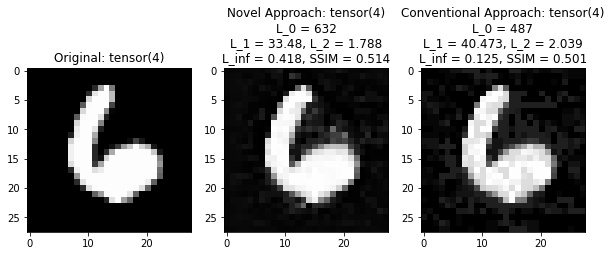

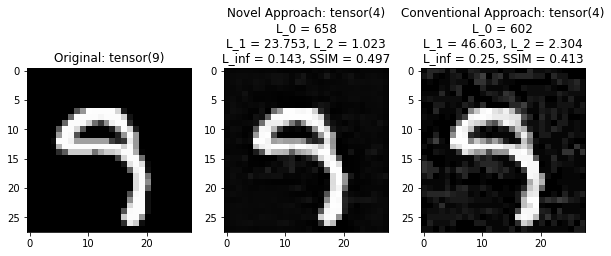

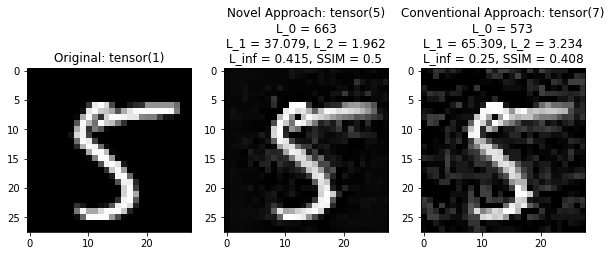

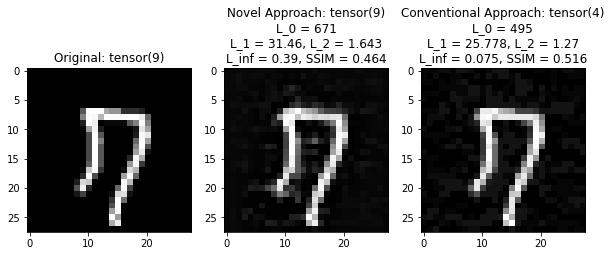

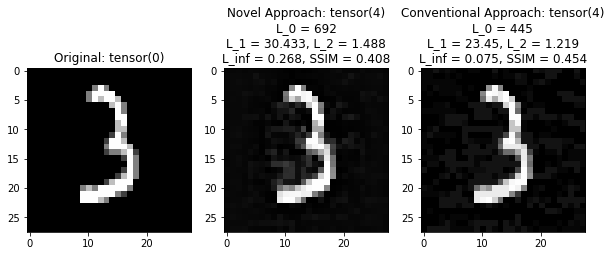

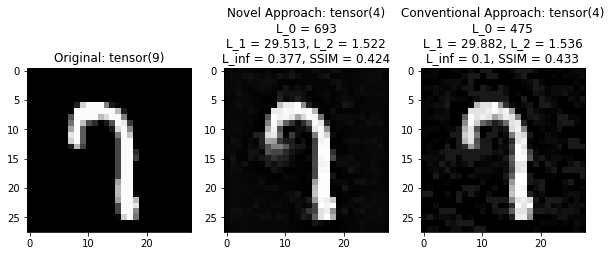

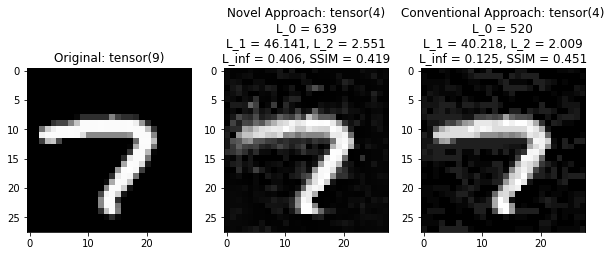

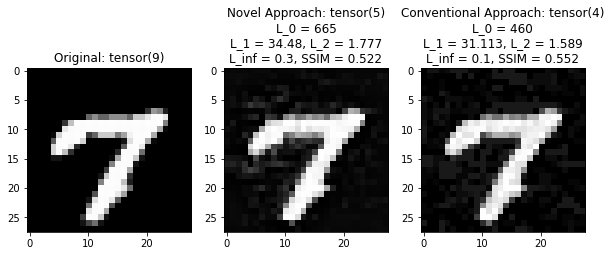

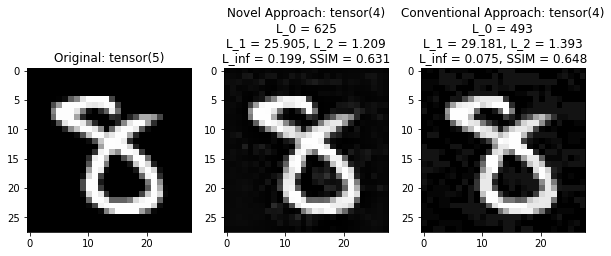

Total Image Count: 150 Success Rate:
 Novel Approach: 0.9622905027932961 Conventional Approach: 0.9217877094972067
Total Image Count: 155 Success Rate:
 Novel Approach: 0.963439404197698 Conventional Approach: 0.9214624238320921
Total Image Count: 160 Success Rate:
 Novel Approach: 0.9613114754098361 Conventional Approach: 0.920655737704918
Total Image Count: 165 Success Rate:
 Novel Approach: 0.961220597584234 Conventional Approach: 0.9205340114431023
Total Image Count: 170 Success Rate:
 Novel Approach: 0.9610870907967881 Conventional Approach: 0.9215565163681285
Total Image Count: 175 Success Rate:
 Novel Approach: 0.9621621621621622 Conventional Approach: 0.9231231231231232
Total Image Count: 180 Success Rate:
 Novel Approach: 0.9631794272355347 Conventional Approach: 0.9240210403272939
Total Image Count: 185 Success Rate:
 Novel Approach: 0.9636363636363636 Conventional Approach: 0.9244318181818182
Total Image Count: 190 Success Rate:
 Novel Approach: 0.9640486725663717 Convention

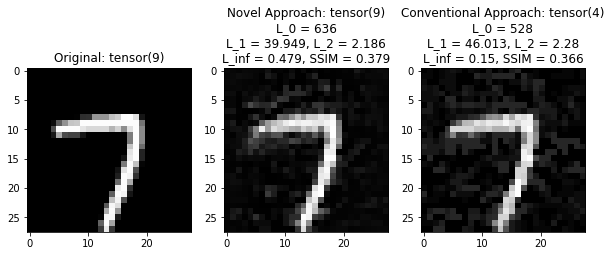

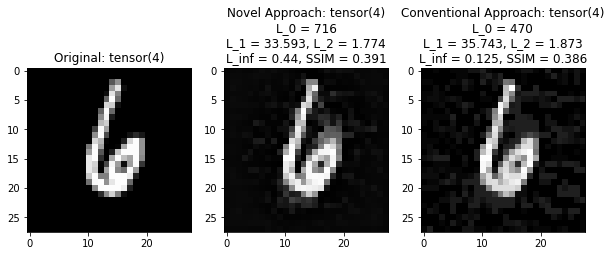

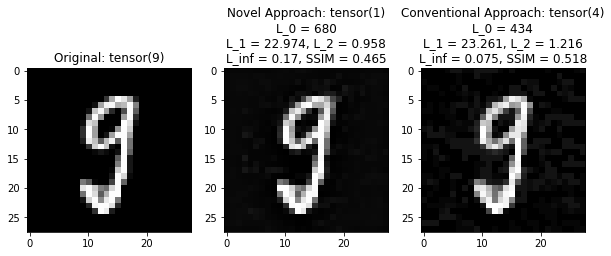

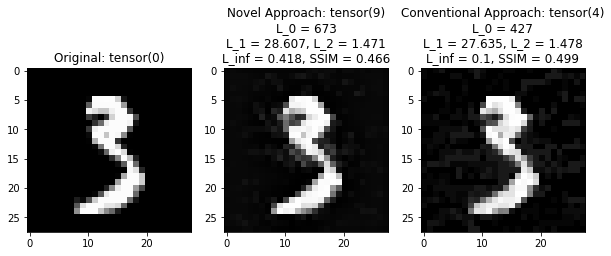

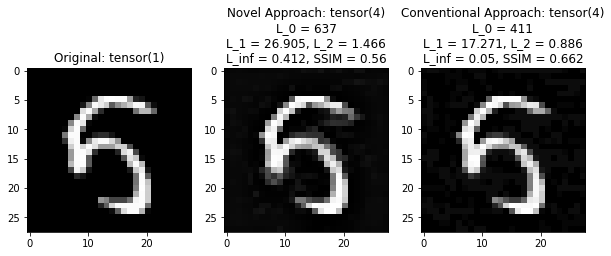

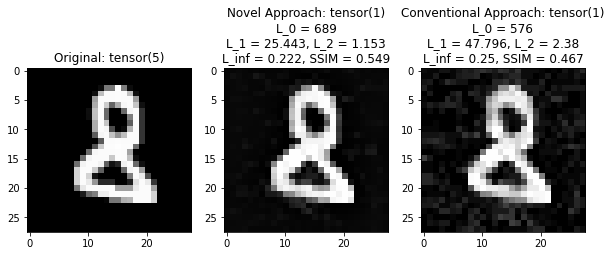

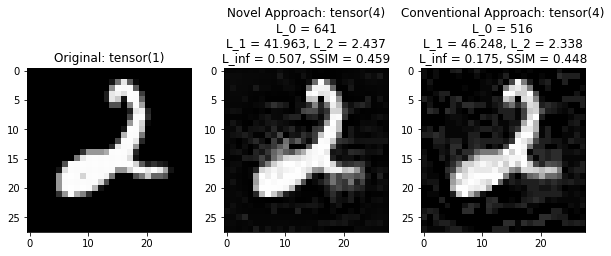

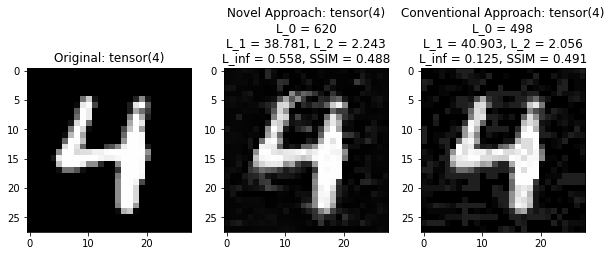

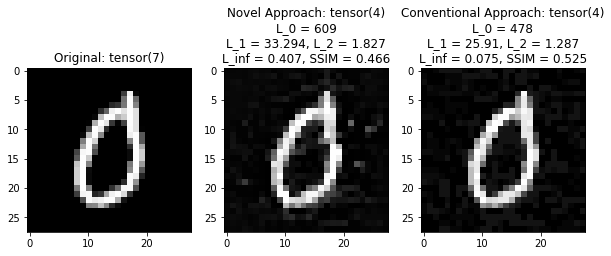

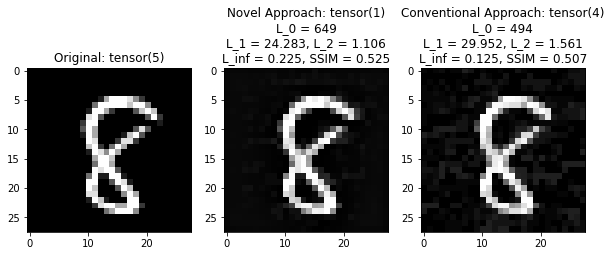

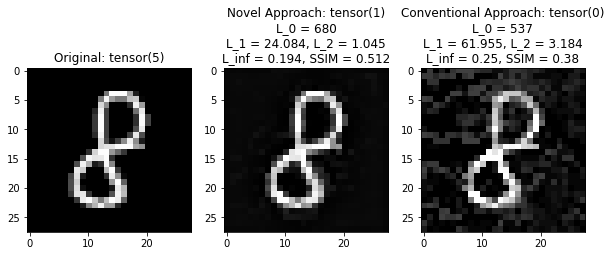

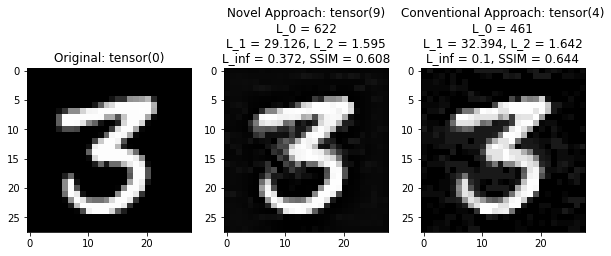

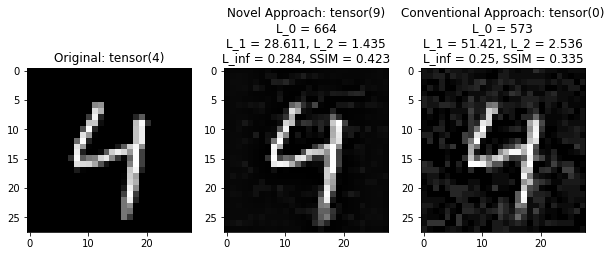

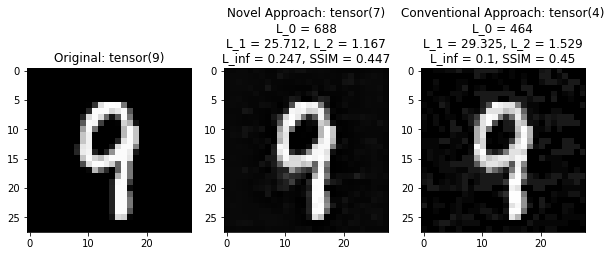

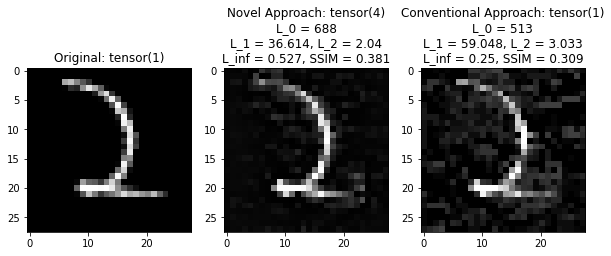

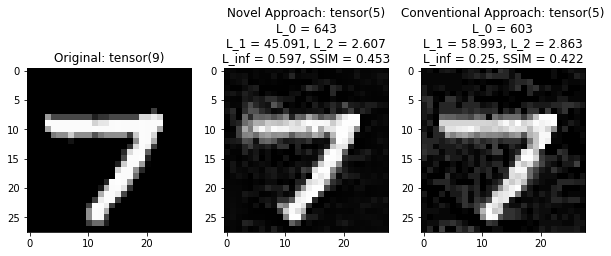

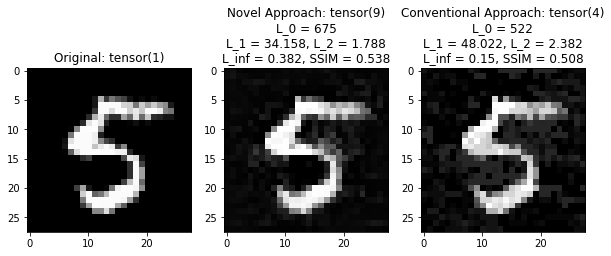

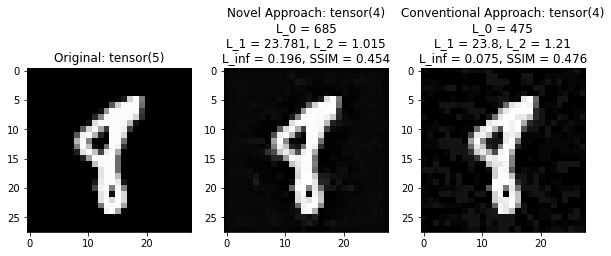

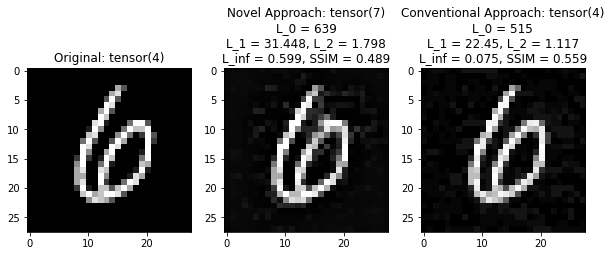

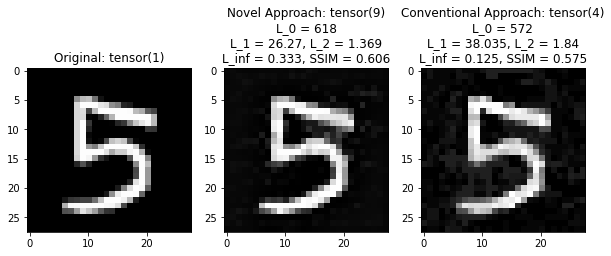

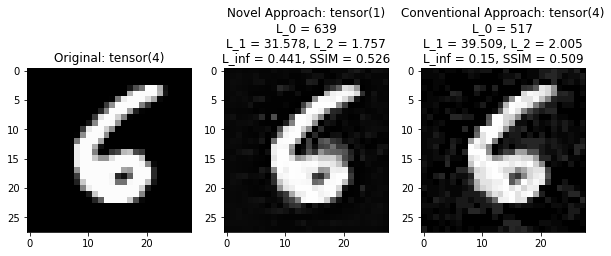

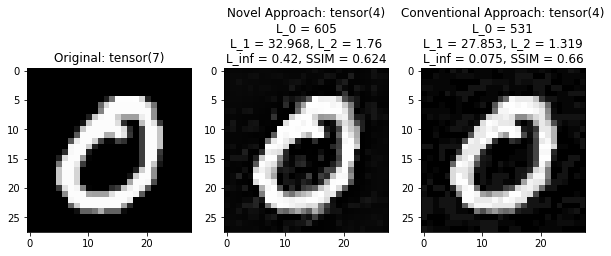

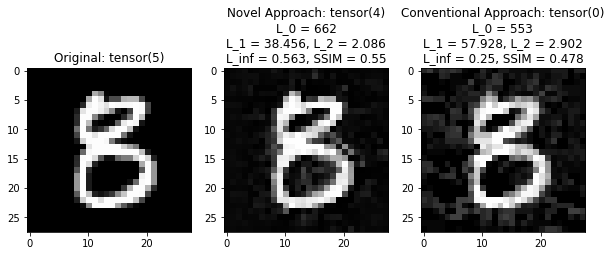

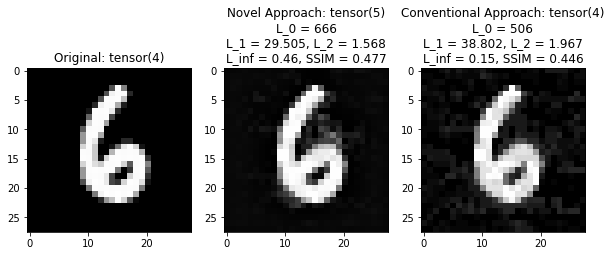

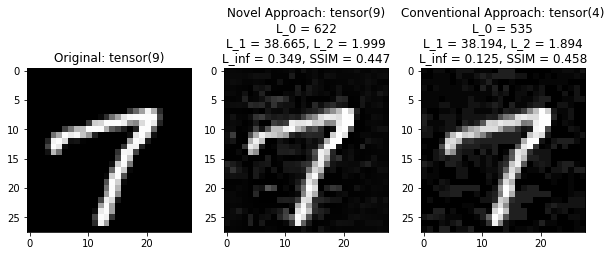

In [ ]:
# PGD TEST
# N = Novel Approach, C = Conventional Approach
model.eval()
success_N = 0
success_C = 0
total = 0
pred_suc = 0
attpre_suc = 0
batch_num = 0
for images, labels in test_loader:
    batch_num += 1
    images = images.to(device)
    labels = labels.to(device)
    outputs_N = model(images)
    _, ori_preds = torch.max(outputs_N, 1)   #original outputs
    index = np.arange(labels.size(0))
    # print(labels.size())
    index = index[ori_preds.cpu() == labels.cpu()]
    # print(images.size())
    images = images[index]
    labels = labels[index]

    # Novel Approach
    att_images_N, deltas = PGD_attack_MyLoss(model, images, labels, eps, step_size)
    att_outputs_N = model(att_images_N)
    _, att_preds_N = torch.max(att_outputs_N, 1)
    success_N += (labels != att_preds_N).sum().item()
    # success += (ori_preds != att_preds_N).sum().item()
    # pred_suc += (ori_preds == labels).sum().item()
    # attpre_suc += (att_preds_N == labels).sum().item()

    # Conventional Approach
    att_images_C, deltas_conv = PGD_attack_Conventional(model, images, labels, eps,step_size=0.025)
    att_outputs_C = model(att_images_C)
    _, att_preds_C = torch.max(att_outputs_C.data, 1)
    success_C += (labels != att_preds_C).sum().item()

    # Display Result
    total += labels.size(0)
    if(batch_num % 10 == 0):
        for i in range (0, images.size()[0]):
            triple_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
                        torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
                        torchvision.utils.make_grid(att_images_C[i].data, normalize=True),
                        "Original: " + str(test_dataset.test_labels[labels[i]]),
                        "Novel Approach: " + str(test_dataset.test_labels[att_preds_N[i]])
                        + '\n' + "L_0 = " + str(round(l0(images[i], att_images_N[i]), 3))
                        + '\n' + "L_1 = " + str(round(l1(images[i],att_images_N[i]),3))
                        + ", L_2 = " + str(round(l2(images[i], att_images_N[i]),3))
                        + '\n' + 'L_inf = ' + str(round(deltas[i],3)) + ', SSIM = ' +
                        str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)),
                        "Conventional Approach: " +str(test_dataset.test_labels[att_preds_C[i]])
                        + '\n' + "L_0 = " + str(round(l0(images[i], att_images_C[i]), 3))
                        + '\n' + "L_1 = " + str(round(l1(images[i],att_images_C[i]),3))
                        + ", L_2 = " + str(round(l2(images[i],att_images_C[i]),3))
                        + '\n' + 'L_inf = ' + str(round(deltas_conv[i],3)) + ', SSIM = ' +
                        str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)),
                        5 * batch_num - 4 + i)
    #     double_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
    #                     torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
    #                     "Original: " + str(train_dataset.classes[labels[i]]),
    #                     "Novel Approach: " + str(train_dataset.classes[att_preds_N[i]])
    #                     + '\n' + str(round(deltas[i],3)))
    #     print('SSIM_N = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)))
    #     print('SSIM_C = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)))

    print("Total Image Count:", 5 * batch_num,"Success Rate:\n", "Novel Approach:", success_N / total, "Conventional Approach:", success_C / total)
    if(batch_num >=  300):
        break